In [1]:
from minicons.minicons import scorer
import torch
import torch.optim as optim

from transformers import AdamW

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(1234)

In [3]:
lm = scorer.IncrementalLMScorer("distilgpt2", "cpu")
model = lm.model
tokenizer = lm.tokenizer

Using pad_token, but it is not set yet.


In [4]:
sentence = "A wug is a bird."
test_sentence = "A wug can fly."
control_sentence = "A wug can dance."

In [5]:
def score(sentence):
    encoded = tokenizer.encode_plus(sentence, return_tensors='pt')
    tokens = encoded['input_ids']
    attention_masks = encoded['attention_mask']
    
    outputs = model(tokens, attention_mask = attention_masks, labels = tokens)
    return outputs.loss

In [6]:
score(test_sentence), score(control_sentence)

(tensor(57.0051, grad_fn=<NllLossBackward>),
 tensor(56.2077, grad_fn=<NllLossBackward>))

In [7]:
optimizer = AdamW(model.parameters(), lr = 5e-4)
losses = []
test_losses = []
control_losses = []
model.train()
for i in range(20):
    optimizer.zero_grad()
    loss = score(sentence)
    losses.append(loss)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        cl = score(control_sentence)
        tl = score(test_sentence)
        test_losses.append(tl)
        control_losses.append(cl)
        model.train()

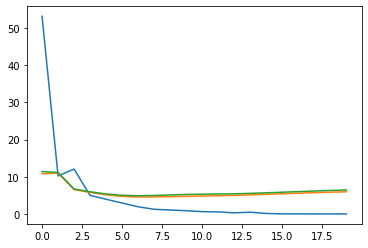

In [8]:
for plot in [losses, test_losses, control_losses]:
    plt.plot(plot)

In [10]:
test_losses

[tensor(10.8456),
 tensor(10.9841),
 tensor(6.5580),
 tensor(5.7774),
 tensor(5.1383),
 tensor(4.7364),
 tensor(4.5687),
 tensor(4.5863),
 tensor(4.6567),
 tensor(4.7381),
 tensor(4.8224),
 tensor(4.9062),
 tensor(4.9948),
 tensor(5.1252),
 tensor(5.2767),
 tensor(5.4319),
 tensor(5.5836),
 tensor(5.7262),
 tensor(5.8563),
 tensor(5.9714)]

In [12]:
score("All monkeys can dax.")

tensor(4.7274, grad_fn=<NllLossBackward>)

In [11]:
test_losses

[tensor(11.9529),
 tensor(6.8418),
 tensor(3.4390),
 tensor(1.7000),
 tensor(0.6183),
 tensor(1.6746),
 tensor(1.7967),
 tensor(1.5105),
 tensor(1.0288),
 tensor(0.8128),
 tensor(0.8223),
 tensor(0.5192),
 tensor(0.3904),
 tensor(0.5005),
 tensor(0.5595),
 tensor(2.7655),
 tensor(4.3241),
 tensor(0.2924),
 tensor(0.1667),
 tensor(0.5292)]

In [18]:
tokenizer.encode_plus(sentence, return_tensors="pt")

{'input_ids': tensor([[ 2025, 17180,   257,  1110,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}